In [1]:
import mdtraj as md
import openmm
from openmm.app.pdbfile import PDBFile
import parmed

In [2]:
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
import copy
from openmm.app import *
from openmm import *
# from unit import *

from math import sqrt
import mdtraj as md
import numpy as np
import tempfile
from parmed import unit as u


from Extractor import BaseExtractor
            
class custom_LiquidExtractor(BaseExtractor):
    """Extraction from condensed phase simulation where the system is composed of one kind of molecule only.

    Parameters
    -----------
    string_identifier : str
        The string identifier tagged as prefix to all values extracted in this class.

    """
    string_identifier = "liquid"

    @classmethod
    def extract_dipole_magnitude(cls, mdtraj_obj, parmed_obj, **kwargs):
        """
        Extracting dipole moment magnitude from each frame of simulation.
        Assumes each residue in the system is a solute.

        Parameters
        -------------
        mdtraj_obj : mdtraj.trajectory
            The simulated trajectory
        parmed_obj : parmed.structure
            Parmed object of the fully parameterised simulated system.

        Returns
        ------------
        df : dict
            Key is prefix_dipole_magnitude, where prefix changes depending on the type of Extractor class used. Values are the corresponding set of numerics, stored as lists.
        """
        solute_atoms_list, _ = cls._solute_solvent_split(mdtraj_obj.topology, **kwargs)
        df = {}

        for idx, solute_atoms in enumerate(solute_atoms_list):
            charges = [i.charge for idx, i in enumerate(parmed_obj.atoms) if idx in solute_atoms]
            solute_mdtraj_obj = mdtraj_obj.atom_slice(list(solute_atoms))
            dipole_magnitudes = [np.linalg.norm(i) for i in md.dipole_moments(solute_mdtraj_obj, charges)]
            df[f"{cls.string_identifier}_dipole_magnitude_{idx}"] = dipole_magnitudes

        return df

    @classmethod
    def _solute_solvent_split(cls, topology, **kwargs):
        """
        Distinguish solutes from solvents, used in :func:`~BaseExtractor._extract_energies_helper`

        The following is assumed:
            - Each residue is considered as a solute molecule


        Parameters
        -----------
        topology : mdtraj.topology

        Returns
        ------------
        solute_atoms_list : list of sets
            List of sets of solute atom indices for each residue.
        solvent_atoms : set
            set of solvent_atoms indices
        """
        solute_atoms_list = []
        solvent_atoms = set()
        for residue in topology.residues:
            solute_atoms = set(atom.index for atom in residue.atoms)
            solute_atoms_list.append(solute_atoms)
        print(f'{len(solute_atoms_list)} residues detected in the system.')
        return solute_atoms_list, solvent_atoms

    @classmethod
    def _get_all_exception_atom_pairs(cls, system, topology, parmed_obj):
        """
        Using the parametersied system to obtain the exception and exclusion pairs, used in :func:`~BaseExtractor._extract_energies_helper`. This is inferred purely from the parameterised system and connectivity.


        Parameters
        -----------
        system : OpenMM.System
        topology : mdtraj.topology
        parmed_obj : parmed.structure

        Returns
        ------------
        solute_1_4_pairs : set
        solvent_1_4_pairs : set
        solute_excluded_pairs : set
        solvent_excluded_pairs : set
        solute_self_pairs : set
        solvent_self_pairs : set
        """


        forces = { force.__class__.__name__ : force for force in system.getForces() }

        angleForce = forces['HarmonicAngleForce']
    #     bondForce = forces['HarmonicBondForce']

        solute_idx_list, solvent_idx_list = cls._solute_solvent_split(topology)
        print(len(solute_idx_list), len(solvent_idx_list), ' passed to _get_all_exception_atom_pairs')
        # solute_1_4_pairs,solvent_1_4_pairs, solute_excluded_pairs, solvent_excluded_pairs, solute_self_pairs, solvent_self_pairs
        solute_1_4_pairs_dict, solvent_1_4_pairs_dict, solute_excluded_pairs_dict, solvent_excluded_pairs_dict, solute_self_pairs_dict, solvent_self_pairs_dict = {}, {}, {}, {}, {}, {}
        for solute_idx,solvent_idx in zip(solute_idx_list, solvent_idx_list):

            #python3, for python2 use  set((b[0].index, b[1].index) if b[0].index < b[1].index else (b[1].index, b[0].index) for b in topology.bonds())
            # bonded_pairs =  {(b[0].index, b[1].index) if b[0].index < b[1].index else (b[1].index, b[0].index) for b in topology.bonds} #XXX some trajectory format does not store connectivity information!
            bonded_pairs ={(b.atom1.idx, b.atom2.idx) if b.atom1.idx < b.atom2.idx else (b.atom1.idx, b.atom2.idx) for b in parmed_obj.bonds}
            angle_ends = set()
            for i in range(angleForce.getNumAngles()):
                particle1,particle2,particle3, *rest = angleForce.getAngleParameters(i)
                angle_ends.add((particle1, particle3) if particle1 < particle3 else (particle3, particle1))

            solute_self_pairs, solvent_self_pairs = set(), set()
            solute_1_4_pairs, solvent_1_4_pairs = set(), set()
            solute_excluded_pairs, solvent_excluded_pairs = set(), set()

            for i in solute_idx:
                solute_self_pairs.add((i, i))
            for i in solvent_idx:
                solvent_self_pairs.add((i, i))

            for pair in bonded_pairs:
                if pair[0] in solute_idx:
                    solute_excluded_pairs.add(pair)
                else:
                    solvent_excluded_pairs.add(pair)

            for pair in angle_ends:
                if pair[0] in solute_idx:
                    solute_excluded_pairs.add(pair)
                else:
                    solvent_excluded_pairs.add(pair)
            try:
                torsionForce = forces['PeriodicTorsionForce']

                for j in  (torsionForce.getTorsionParameters(i) for i in range(torsionForce.getNumTorsions())):
                    #if improper torsion, this pair should be bonded
                    pair = (j[0], j[2]) if j[0] < j[2] else (j[2], j[0])
                    if pair in bonded_pairs:
                        continue

                    # real atom pair separated by 3 bonds
                    pair = (j[0], j[3]) if j[0] < j[3] else (j[3], j[0])
                    if pair in angle_ends or pair in bonded_pairs:
                        continue

                    elif pair[0] in solute_idx:
                        solute_1_4_pairs.add(pair)
                    else:
                        solvent_1_4_pairs.add(pair)
            except KeyError:
                pass

            solute_1_4_pairs_dict[solute_idx] = solute_1_4_pairs
            solvent_1_4_pairs_dict[solvent_idx] = solvent_1_4_pairs
            solute_excluded_pairs_dict[solute_idx] = solute_excluded_pairs
            solvent_excluded_pairs_dict[solvent_idx] = solvent_excluded_pairs
            solute_self_pairs_dict[solute_idx] = solute_self_pairs
            solvent_self_pairs_dict[solvent_idx] = solvent_self_pairs

        return solute_1_4_pairs_dict,solvent_1_4_pairs_dict, solute_excluded_pairs_dict, solvent_excluded_pairs_dict, solute_self_pairs_dict, solvent_self_pairs_dict

    @classmethod
    def _extract_energies_helper(cls, mdtraj_obj, parmed_obj, platform = "CPU", **kwargs):
            """
            Helper function for extracting the various energetic components described in the original publication from each frame of simulation. OpenMM.CustomNonbondedForces are used. Specifically, the reaction field defintion is taken from GROMOS96 manual.

            Parameters
            -------------
            mdtraj_obj : mdtraj.trajectory
                The simulated trajectory
            parmed_obj : parmed.structure
                Parmed object of the fully parameterised simulated system.
            platform : str
                The computing architecture to do the calculation, default to CPU, CUDA, OpenCL is also possible.
            Returns
            --------------
            context : Openmm.Context
            integrator : Openmm.Integrator
            """
            parm, traj = parmed_obj, mdtraj_obj

            system = parm.createSystem(nonbondedMethod=CutoffPeriodic, nonbondedCutoff=1.0*unit.nanometer, constraints=AllBonds)
            for i in system.getForces():
                i.setForceGroup(0)

            # topology = parm.topology #XXX here I made the change
            topology = mdtraj_obj.topology
            solute_atoms, solvent_atoms = cls._solute_solvent_split(topology, **kwargs)
            solute_1_4_pairs_dict,solvent_1_4_pairs_dict, solute_excluded_pairs_dict, solvent_excluded_pairs_dict, solute_self_pairs_dict, solvent_self_pairs_dict = cls._get_all_exception_atom_pairs(system, topology, parmed_obj)
            
            context_dict, integrator_dict = {}, {}
            for index, (solute_1_4_pairs, solvent_1_4_pairs, solute_excluded_pairs, solvent_excluded_pairs, solute_self_pairs, solvent_self_pairs) in enumerate(zip(solute_1_4_pairs_dict, solvent_1_4_pairs_dict, solute_excluded_pairs_dict, solvent_excluded_pairs_dict, solute_self_pairs_dict, solvent_self_pairs_dict)):
                print(f"Processing residue {index}")
                forces = { force.__class__.__name__ : force for force in system.getForces() }
                nonbonded_force = forces['NonbondedForce']
                r_cutoff = nonbonded_force.getCutoffDistance()
                try:
                    nonbonded_force.setReactionFieldDielectric(kwargs["solvent_dielectric"])
                except KeyError or TypeError:
                    pass
                epsilon_solv = nonbonded_force.getReactionFieldDielectric()

                ONE_4PI_EPS0 = 138.935456
                c_rf = r_cutoff**(-1) * ((3*epsilon_solv) / (2*epsilon_solv + 1))
                k_rf = r_cutoff**(-3) * ((epsilon_solv - 1) / (2*epsilon_solv + 1))


                cls.group_number = 1
                cls.group_name2num = {}

                def update_grouping(name, force):

                    if name in cls.group_name2num:
                        cls.group_name2num[name].append(cls.group_number)
                    else:
                        cls.group_name2num[name] = [cls.group_number]
                    force.setForceGroup(cls.group_number)
                    cls.group_number += 1

                V_lj = """4*epsilon*(((sigma/r)^6)^2 - (sigma/r)^6);
                    epsilon = sqrt(epsilon1 * epsilon2);
                    sigma = 0.5*(sigma1+sigma2)
                """

                V_crf = """(q1*q2*ONE_4PI_EPS0)*(r^(-1) + (k_rf)*(r^2) - (c_rf));
                    ONE_4PI_EPS0 = %.16e;
                    c_rf = %f;
                    k_rf = %f
                """ % (ONE_4PI_EPS0, c_rf.value_in_unit_system(u.md_unit_system), k_rf.value_in_unit_system(u.md_unit_system))

                V_14_lj = "2^(-1)* 4*epsilon*(((sigma/r)^6)^2 - (sigma/r)^6)" #calling them xepsilon and xsigma just to see if this interferes with the `addPerParticleParameter` below

                V_14_crf = """(1.2)^(-1)*(q_prod*ONE_4PI_EPS0)*(r^(-1) + (k_rf)*(r^2) - (c_rf));
                    ONE_4PI_EPS0 = %.16e;
                    c_rf = %f;
                    k_rf = %f
                """ % (ONE_4PI_EPS0, c_rf.value_in_unit_system(u.md_unit_system), k_rf.value_in_unit_system(u.md_unit_system))

                V_excluded_crf = """(q_prod*ONE_4PI_EPS0)*( (k_rf)*(r^2) - (c_rf));
                    ONE_4PI_EPS0 = %.16e;
                    c_rf = %f;
                    k_rf = %f
                """ % (ONE_4PI_EPS0, c_rf.value_in_unit_system(u.md_unit_system), k_rf.value_in_unit_system(u.md_unit_system))

                V_self_crf = """0.5 * (q_prod*ONE_4PI_EPS0)*(  - (c_rf));
                    ONE_4PI_EPS0 = %.16e;
                    c_rf = %f;
                    k_rf = %f
                """ % (ONE_4PI_EPS0, c_rf.value_in_unit_system(u.md_unit_system), k_rf.value_in_unit_system(u.md_unit_system))
                #######################
                ####################### Normal LJ, solute-solute
                #######################

                new_force = CustomNonbondedForce(V_lj)
                new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)
                new_force.setCutoffDistance(r_cutoff)
                new_force.addPerParticleParameter('sigma')
                new_force.addPerParticleParameter('epsilon')

                for particle in range(nonbonded_force.getNumParticles()):
                    [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                    new_force.addParticle([sigma, epsilon])


                new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
                new_force.addInteractionGroup(solute_atoms, solute_atoms)

                update_grouping("intra_lj", new_force)
                system.addForce(new_force)

                #######################
                ####################### Normal LJ, solute-solvent
                #######################


                new_force = CustomNonbondedForce(V_lj)
                new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)
                new_force.setCutoffDistance(r_cutoff)
                new_force.addPerParticleParameter('sigma')
                new_force.addPerParticleParameter('epsilon')

                for particle in range(nonbonded_force.getNumParticles()):
                    [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                    new_force.addParticle([sigma, epsilon])


                new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
                new_force.addInteractionGroup(solute_atoms, solvent_atoms)

                update_grouping("inter_lj", new_force)
                system.addForce(new_force)

                #######################
                ####################### Normal LJ, solvent-solvent
                #######################


                new_force = CustomNonbondedForce(V_lj)
                new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)
                new_force.setCutoffDistance(r_cutoff)
                new_force.addPerParticleParameter('sigma')
                new_force.addPerParticleParameter('epsilon')

                for particle in range(nonbonded_force.getNumParticles()):
                    [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                    new_force.addParticle([sigma, epsilon])


                new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
                new_force.addInteractionGroup(solvent_atoms, solvent_atoms)

                update_grouping("solvent_lj", new_force)
                system.addForce(new_force)

                #######################
                ####################### Normal CRF, solute-solute
                #######################

                new_force = CustomNonbondedForce(V_crf)

                new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)

                r_cutoff = nonbonded_force.getCutoffDistance()
                new_force.setCutoffDistance(r_cutoff)
                new_force.addPerParticleParameter('q')

                for particle in range(nonbonded_force.getNumParticles()):
                    [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                    new_force.addParticle([charge])

                new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
                new_force.addInteractionGroup(solute_atoms, solute_atoms)


                update_grouping("intra_crf", new_force)
                system.addForce(new_force)


                #######################
                ####################### Normal CRF, solute-solvent
                #######################

                new_force = CustomNonbondedForce(V_crf)

                new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)

                r_cutoff = nonbonded_force.getCutoffDistance()
                new_force.setCutoffDistance(r_cutoff)
                new_force.addPerParticleParameter('q')

                for particle in range(nonbonded_force.getNumParticles()):
                    [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                    new_force.addParticle([charge])

                new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
                new_force.addInteractionGroup(solute_atoms, solvent_atoms)


                update_grouping("inter_crf", new_force)
                system.addForce(new_force)

                #######################
                ####################### Normal CRF, solvent-solvent
                #######################

                new_force = CustomNonbondedForce(V_crf)

                new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)

                r_cutoff = nonbonded_force.getCutoffDistance()
                new_force.setCutoffDistance(r_cutoff)
                new_force.addPerParticleParameter('q')

                for particle in range(nonbonded_force.getNumParticles()):
                    [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                    new_force.addParticle([charge])

                new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
                new_force.addInteractionGroup(solvent_atoms, solvent_atoms)


                update_grouping("solvent_crf", new_force)
                system.addForce(new_force)

                #######################
                ####################### 1-4 scaled lj, solute
                #######################

                new_force = CustomBondForce(V_14_lj)
                new_force.addPerBondParameter('sigma')
                new_force.addPerBondParameter('epsilon')

                for atom_pair in solute_1_4_pairs:
                    charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                    charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                    sigma = 0.5*(sigma1+sigma2)
                    epsilon = (epsilon1 * epsilon2).sqrt()

                    new_force.addBond(atom_pair[0], atom_pair[1], [sigma.value_in_unit_system(u.md_unit_system), epsilon.value_in_unit_system(u.md_unit_system)])

                update_grouping("intra_lj", new_force)
                system.addForce(new_force)

                #######################
                ####################### 1-4 scaled lj, solvent
                #######################

                new_force = CustomBondForce(V_14_lj)
                new_force.addPerBondParameter('sigma')
                new_force.addPerBondParameter('epsilon')

                for atom_pair in solvent_1_4_pairs:
                    charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                    charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                    sigma = 0.5*(sigma1+sigma2)
                    epsilon = (epsilon1 * epsilon2).sqrt()

                    new_force.addBond(atom_pair[0], atom_pair[1], [sigma.value_in_unit_system(u.md_unit_system), epsilon.value_in_unit_system(u.md_unit_system)])

                update_grouping("solvent_lj", new_force)
                system.addForce(new_force)

                ##########################
                ########################## 1-4 scaled crf, solute
                ##########################

                new_force = CustomBondForce(V_14_crf)
                new_force.addPerBondParameter('q_prod')


                for atom_pair in solute_1_4_pairs:

                    charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                    charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                    charge = charge1 * charge2
                    new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

                update_grouping("intra_crf", new_force)
                system.addForce(new_force)


                ##########################
                ########################## 1-4 scaled crf, solvent
                ##########################

                new_force = CustomBondForce(V_14_crf)
                new_force.addPerBondParameter('q_prod')


                for atom_pair in solvent_1_4_pairs:
                    charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                    charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                    charge = charge1 * charge2
                    new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

                update_grouping("solvent_crf", new_force)
                system.addForce(new_force)


                #######################
                ####################### Excluded pairs electrostatics ONLY, solute (1-2, 1-3)
                #######################

                new_force = CustomBondForce(V_excluded_crf)
                new_force.addPerBondParameter('q_prod')

                for atom_pair in solute_excluded_pairs:
                    charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                    charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                    charge = charge1 * charge2

                    new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

                update_grouping("intra_crf", new_force)
                system.addForce(new_force)

                #######################
                ####################### Excluded pairs electrostatics ONLY, solvent (1-2, 1-3)
                #######################

                new_force = CustomBondForce(V_excluded_crf)
                new_force.addPerBondParameter('q_prod')

                for atom_pair in solvent_excluded_pairs:
                    charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                    charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                    charge = charge1 * charge2

                    new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

                update_grouping("solvent_crf", new_force)
                system.addForce(new_force)

                #######################
                ####################### Self pairs electrostatics ONLY, solute
                #######################

                new_force = CustomBondForce(V_self_crf)
                new_force.addPerBondParameter('q_prod')

                for atom_pair in solute_self_pairs:

                    charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                    charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                    charge = charge1 * charge2

                    new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

                update_grouping("intra_crf", new_force)
                system.addForce(new_force)

                #######################
                ####################### Self pairs electrostatics ONLY, solvent
                #######################

                new_force = CustomBondForce(V_self_crf)
                new_force.addPerBondParameter('q_prod')

                for atom_pair in solute_self_pairs:

                    charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                    charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                    charge = charge1 * charge2

                    new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

                update_grouping("solvent_crf", new_force)
                system.addForce(new_force)

                #######################
                #######################
                #######################

                system.removeForce([force.getForceGroup() for force in system.getForces() if force.__class__.__name__  == "NonbondedForce" ][0])

                # for i in system.getForces():
                #     print(i,i.getForceGroup())

                integrator = LangevinIntegrator(298.15*u.kelvin, 1/u.picosecond, 0.002*u.picoseconds)
                platform = Platform.getPlatformByName(platform)
                context = Context(system, integrator, platform)


                if parm.box_vectors is not None:
                    context.setPeriodicBoxVectors(*parm.box_vectors) #TODO might be better to take the boxes from traj

                context_dict[index] = context
                integrator_dict[index] = integrator

            return context_dict, integrator_dict
    @classmethod
    def extract_energies(cls, mdtraj_obj, parmed_obj, platform = "CPU", **kwargs):
            """
            Extracting the various energetic components described in the original publication from each frame of simulation.

            Parameters
            -------------
            mdtraj_obj : mdtraj.trajectory
                The simulated trajectory
            parmed_obj : parmed.structure
                Parmed object of the fully parameterised simulated system.
            platform : str
                The computing architecture to do the calculation, default to CPU, CUDA, OpenCL is also possible.

            Returns
            ------------
            df : dict
                Keys are each of the energetic type features. e.g. "intra_lj" are the intra-molecular LJ energies obtained from simulation.

                Values are the corresponding set of numerics, stored as lists.
            """
            

            df_list = []
            context_dict, integrator_dict = cls._extract_energies_helper(mdtraj_obj, parmed_obj, platform = "CPU", **kwargs)

            for context, integrator in zip(context_dict, integrator_dict):
                df = {}

                df["{}_intra_crf".format(cls.string_identifier)] = []
                df["{}_intra_lj".format(cls.string_identifier)] = []
                df["{}_total_crf".format(cls.string_identifier)] = []
                df["{}_total_lj".format(cls.string_identifier)] = []
                
                #TODO can speed up the for loop?????
                for i in range(len(mdtraj_obj)):
                    context.setPositions(mdtraj_obj.openmm_positions(i))

                    df["{}_intra_crf".format(cls.string_identifier)].append(context.getState(getEnergy=True, groups=set(cls.group_name2num["intra_crf"])).getPotentialEnergy()._value)
                    df["{}_intra_lj".format(cls.string_identifier)].append(context.getState(getEnergy=True, groups=set(cls.group_name2num["intra_lj"])).getPotentialEnergy()._value)
                    df["{}_total_crf".format(cls.string_identifier)].append(context.getState(getEnergy=True, groups=set(cls.group_name2num["intra_crf"] + cls.group_name2num["inter_crf"])).getPotentialEnergy()._value)
                    df["{}_total_lj".format(cls.string_identifier)].append(context.getState(getEnergy=True, groups=set(cls.group_name2num["intra_lj"] + cls.group_name2num["inter_lj"])).getPotentialEnergy()._value)


                #TODO can speed up the for loop?????
                df["{}_intra_ene".format(cls.string_identifier)] = [sum(x) for x in zip(df["{}_intra_crf".format(cls.string_identifier)], df["{}_intra_lj".format(cls.string_identifier)])]

                #TODO can speed up the for loop?????
                df["{}_total_ene".format(cls.string_identifier)] = [sum(x) for x in zip(df["{}_total_crf".format(cls.string_identifier)], df["{}_total_lj".format(cls.string_identifier)])]

                del context, integrator
                df_list.append(df)
            return df_list


In [4]:
def solute_solvent_split( topology):
    solute_atoms_list = []
    solvent_atoms = set()
    for residue in topology.residues:
        solute_atoms = set(atom.index for atom in residue.atoms)
        solute_atoms_list.append(solute_atoms)
        solvent_atoms = set(atom.index for atom in topology.atoms if atom.index not in solute_atoms)
    print(f'{len(solute_atoms_list)} residues detected in the system.')
    return solute_atoms_list, solvent_atoms


In [ ]:
for res in traj.topology.residues:
    print(res.name, res.index)

BRO 0
BRO 1
BRO 2
BRO 3
BRO 4
BRO 5
BRO 6
BRO 7
BRO 8
BRO 9
BRO 10
BRO 11
BRO 12
BRO 13
BRO 14
BRO 15
BRO 16
BRO 17
BRO 18
BRO 19
BRO 20
BRO 21
BRO 22
BRO 23
BRO 24
BRO 25
BRO 26
BRO 27
BRO 28
BRO 29
BRO 30
BRO 31
BRO 32
BRO 33
BRO 34
BRO 35
BRO 36
BRO 37
BRO 38
BRO 39
BRO 40
BRO 41
BRO 42
BRO 43
BRO 44
BRO 45
BRO 46
BRO 47
BRO 48
BRO 49
BRO 50
BRO 51
BRO 52
BRO 53
BRO 54
BRO 55
BRO 56
BRO 57
BRO 58
BRO 59
BRO 60
BRO 61
BRO 62
BRO 63
BRO 64
BRO 65
BRO 66
BRO 67
BRO 68
BRO 69
BRO 70
BRO 71
BRO 72
BRO 73
BRO 74
BRO 75
BRO 76
BRO 77
BRO 78
BRO 79
BRO 80
BRO 81
BRO 82
BRO 83
BRO 84
BRO 85
BRO 86
BRO 87
BRO 88
BRO 89
BRO 90
BRO 91
BRO 92
BRO 93
BRO 94
BRO 95
BRO 96
BRO 97
BRO 98
BRO 99


In [ ]:
res1 = traj.topology.residue(0)
other_res = [res for res in traj.topology.residues if res.index != 0]

In [ ]:
def solute_solvent_split(topology):
    #make all split; one residue is the solute, and the others are the solvent. do this for all residues
    solute_atoms_list = []
    solvent_atoms_list = []
    for res in topology.residues:
        solute_atoms = set(atom.index for atom in res.atoms)
        solvent_atoms = set(atom.index for atom in topology.atoms if atom.index not in solute_atoms)
        solute_atoms_list.append(solute_atoms)
        solvent_atoms_list.append(solvent_atoms)
    return solute_atoms_list, solvent_atoms_list

solute_atoms_list, solvent_atoms_list = solute_solvent_split(traj.topology)
print(len(solute_atoms_list), len(solvent_atoms_list))
print(len(solute_atoms_list[0]), len(solvent_atoms_list[0]))
assert len(solute_atoms_list) == len(solvent_atoms_list)
assert len(solvent_atoms_list[0]) == 99 * len(solute_atoms_list[0])

100 100
12 1188


In [ ]:
for res in traj.topology.residues:
    print(res.n_atoms,len([r for r in traj.topology.residues if r != res]))

12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99
12 99


In [ ]:
#apply
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n100.h5'
key = 'adb70b0f9c8b43a9a9373ada67a25377'
prm_obj = load_prmed(key)
traj = md.load(path)
out = custom_LiquidExtractor.extract_energies(mdtraj_obj=traj, parmed_obj=prm_obj)
out

100 residues detected in the system.
100 residues detected in the system.
100 0  passed to _get_all_exception_atom_pairs


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


[]

In [8]:
def load_prmed(schema_id):
    pdb_file = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/liquid_phase_experiment_daata/{schema_id}_build_coordinates/output.pdb'
    parameterized_system = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/liquid_phase_experiment_daata/{schema_id}_assign_parameters/system.xml'
    omm_top = PDBFile(pdb_file).topology
    omm_sys = openmm.XmlSerializer.deserialize(open(parameterized_system).read())
    rdk_pmd = parmed.openmm.load_topology(omm_top, omm_sys, xyz=pdb_file)
    return rdk_pmd
def load_traj(n):
    return md.load(f'liquid_phase_experiment_daata/test_benzene_full_equil_n{n}.h5')

In [ ]:
import mdtraj as md
import openmm
from openmm.app.pdbfile import PDBFile
import parmed

In [ ]:
smiles = 'c1ccccc1'

In [ ]:
def get_and_plot_dipoles(key,path,title=None):
    prm_obj = load_prmed(key)
    traj = md.load(path)
    dipoles = LiquidExtractor.extract_dipole_magnitude(traj, prm_obj)
    dipole_vals = np.concatenate([v for k,v in dipoles.items()])
    plt.hist(dipole_vals)
    if title:
        plt.title(title)
    plt.show()
    return dipoles

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/topology.py:91: UserWarning: atom_indices are not monotonically increasing
  warnings.warn('atom_indices are not monotonically increasing')


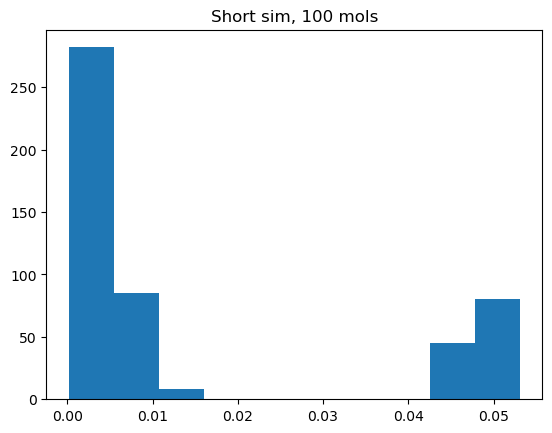

In [ ]:
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n100.h5'
key = 'adb70b0f9c8b43a9a9373ada67a25377'
dipoles = get_and_plot_dipoles(key,path,title='Short sim, 100 mols')

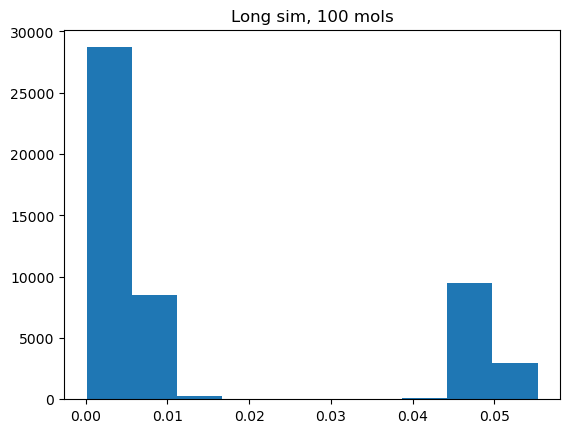

In [ ]:
key = 'adb70b0f9c8b43a9a9373ada67a25377'
path = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/liquid_phase_experiment_daata/test_benzene_full_equil_n100_5ns.h5'
dipoles = get_and_plot_dipoles(key,path,title='Long sim, 100 mols')

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/topology.py:91: UserWarning: atom_indices are not monotonically increasing
  warnings.warn('atom_indices are not monotonically increasing')


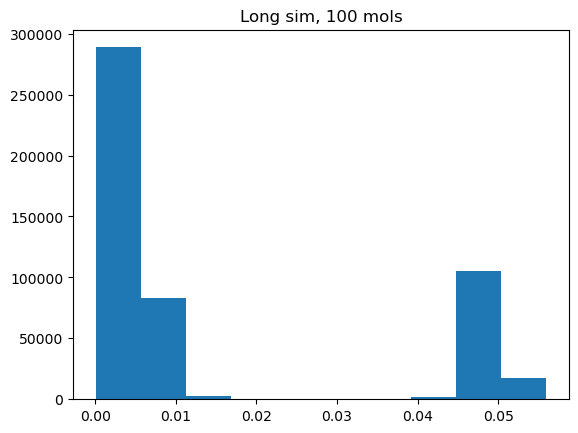

In [ ]:
key = '0071386446c342529f1bb7c14316c4e7'
path = f'/localhome/cschiebroek/MDFP_VP/mdfptools/carl/liquid_phase_experiment_daata/test_benzene_full_equil_n1000_5ns.h5'
liquid_extractor = LiquidExtractor()
dipole_data_1000_5ns = get_and_plot_dipoles(key,path,title='Long sim, 100 mols')

In [ ]:
def get_energies(key,path):
    prm_obj = load_prmed(key)
    traj = md.load(path)
    energies = LiquidExtractor.extract_energies(traj, prm_obj)
    return energies

In [ ]:
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n100.h5'
key = 'adb70b0f9c8b43a9a9373ada67a25377'
dipoles = get_energies(key,path)

TypeError: unhashable type: 'set'

In [ ]:
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n100.h5'
key = 'adb70b0f9c8b43a9a9373ada67a25377'
energies_default = get_energies(key,path)
energies_default

{'liquid_intra_crf': [8.42604953770342,
  8.44421759205861,
  8.587319276643452,
  8.370973737469804,
  8.380564497530415],
 'liquid_intra_lj': [22.27447066980661,
  22.01709602631562,
  22.51988008234233,
  24.590652147151065,
  22.64277497271367],
 'liquid_total_crf': [4.052440490071714,
  5.100912071442888,
  4.019444482596111,
  2.30831268878568,
  3.392649151765198],
 'liquid_total_lj': [-28.670053533426305,
  -13.616838476751429,
  -13.988738438142292,
  -3.9123642180441784,
  -10.508165825612934],
 'liquid_intra_ene': [30.70052020751003,
  30.46131361837423,
  31.10719935898578,
  32.96162588462087,
  31.023339470244085],
 'liquid_total_ene': [-24.61761304335459,
  -8.51592640530854,
  -9.969293955546181,
  -1.6040515292584985,
  -7.115516673847736]}

In [5]:
def get_energies(key,path):
    prm_obj = load_prmed(key)
    traj = md.load(path)
    energies = LiquidExtractor.extract_energies(traj, prm_obj,0)
    return energies

In [9]:
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
import copy
from openmm.app import *
from openmm import *
# from unit import *

from math import sqrt
import mdtraj as md
import numpy as np
import tempfile
from parmed import unit as u


class customBaseExtractor():
    """

    .. warning :: The base class should not be used directly

    """
    #FIXME make epsilon variable 
    string_identifier = "!Should_Call_From_Inherited_Class"

    @classmethod
    def _solute_solvent_split(cls, topology,solute_idx, **kwargs):
        """
        Abstract method
        """
        raise NotImplementedError

    @classmethod
    def _get_all_exception_atom_pairs(cls, system, topology, parmed_obj):
        """
        Abstract method
        """
        raise NotImplementedError

    @classmethod
    def _extract_energies_helper(cls, mdtraj_obj, parmed_obj, platform = "CPU",solute_idx=None, **kwargs):
            """
            Helper function for extracting the various energetic components described in the original publication from each frame of simulation. OpenMM.CustomNonbondedForces are used. Specifically, the reaction field defintion is taken from GROMOS96 manual.

            Parameters
            -------------
            mdtraj_obj : mdtraj.trajectory
                The simulated trajectory
            parmed_obj : parmed.structure
                Parmed object of the fully parameterised simulated system.
            platform : str
                The computing architecture to do the calculation, default to CPU, CUDA, OpenCL is also possible.
            Returns
            --------------
            context : Openmm.Context
            integrator : Openmm.Integrator
            """
            parm, traj = parmed_obj, mdtraj_obj

            system = parm.createSystem(nonbondedMethod=CutoffPeriodic, nonbondedCutoff=1.0*unit.nanometer, constraints=AllBonds)
            for i in system.getForces():
                i.setForceGroup(0)

            # topology = parm.topology #XXX here I made the change
            topology = mdtraj_obj.topology
            solute_atoms, solvent_atoms = cls._solute_solvent_split(topology,solute_idx, **kwargs)
            solute_1_4_pairs, solvent_1_4_pairs, solute_excluded_pairs, solvent_excluded_pairs, solute_self_pairs, solvent_self_pairs = cls._get_all_exception_atom_pairs(system, topology, parmed_obj,solute_idx=solute_idx)



            forces = { force.__class__.__name__ : force for force in system.getForces() }
            nonbonded_force = forces['NonbondedForce']
            r_cutoff = nonbonded_force.getCutoffDistance()
            try:
                nonbonded_force.setReactionFieldDielectric(kwargs["solvent_dielectric"])
            except KeyError or TypeError:
                pass
            epsilon_solv = nonbonded_force.getReactionFieldDielectric()

            ONE_4PI_EPS0 = 138.935456
            c_rf = r_cutoff**(-1) * ((3*epsilon_solv) / (2*epsilon_solv + 1))
            k_rf = r_cutoff**(-3) * ((epsilon_solv - 1) / (2*epsilon_solv + 1))


            cls.group_number = 1
            cls.group_name2num = {}

            def update_grouping(name, force):

                if name in cls.group_name2num:
                    cls.group_name2num[name].append(cls.group_number)
                else:
                    cls.group_name2num[name] = [cls.group_number]
                force.setForceGroup(cls.group_number)
                cls.group_number += 1

            V_lj = """4*epsilon*(((sigma/r)^6)^2 - (sigma/r)^6);
                epsilon = sqrt(epsilon1 * epsilon2);
                sigma = 0.5*(sigma1+sigma2)
            """

            V_crf = """(q1*q2*ONE_4PI_EPS0)*(r^(-1) + (k_rf)*(r^2) - (c_rf));
                ONE_4PI_EPS0 = %.16e;
                c_rf = %f;
                k_rf = %f
            """ % (ONE_4PI_EPS0, c_rf.value_in_unit_system(u.md_unit_system), k_rf.value_in_unit_system(u.md_unit_system))

            V_14_lj = "2^(-1)* 4*epsilon*(((sigma/r)^6)^2 - (sigma/r)^6)" #calling them xepsilon and xsigma just to see if this interferes with the `addPerParticleParameter` below

            V_14_crf = """(1.2)^(-1)*(q_prod*ONE_4PI_EPS0)*(r^(-1) + (k_rf)*(r^2) - (c_rf));
                ONE_4PI_EPS0 = %.16e;
                c_rf = %f;
                k_rf = %f
            """ % (ONE_4PI_EPS0, c_rf.value_in_unit_system(u.md_unit_system), k_rf.value_in_unit_system(u.md_unit_system))

            V_excluded_crf = """(q_prod*ONE_4PI_EPS0)*( (k_rf)*(r^2) - (c_rf));
                ONE_4PI_EPS0 = %.16e;
                c_rf = %f;
                k_rf = %f
            """ % (ONE_4PI_EPS0, c_rf.value_in_unit_system(u.md_unit_system), k_rf.value_in_unit_system(u.md_unit_system))

            V_self_crf = """0.5 * (q_prod*ONE_4PI_EPS0)*(  - (c_rf));
                ONE_4PI_EPS0 = %.16e;
                c_rf = %f;
                k_rf = %f
            """ % (ONE_4PI_EPS0, c_rf.value_in_unit_system(u.md_unit_system), k_rf.value_in_unit_system(u.md_unit_system))
            #######################
            ####################### Normal LJ, solute-solute
            #######################

            new_force = CustomNonbondedForce(V_lj)
            new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)
            new_force.setCutoffDistance(r_cutoff)
            new_force.addPerParticleParameter('sigma')
            new_force.addPerParticleParameter('epsilon')

            for particle in range(nonbonded_force.getNumParticles()):
                [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                new_force.addParticle([sigma, epsilon])


            new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
            new_force.addInteractionGroup(solute_atoms, solute_atoms)

            update_grouping("intra_lj", new_force)
            system.addForce(new_force)

            #######################
            ####################### Normal LJ, solute-solvent
            #######################


            new_force = CustomNonbondedForce(V_lj)
            new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)
            new_force.setCutoffDistance(r_cutoff)
            new_force.addPerParticleParameter('sigma')
            new_force.addPerParticleParameter('epsilon')

            for particle in range(nonbonded_force.getNumParticles()):
                [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                new_force.addParticle([sigma, epsilon])


            new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
            new_force.addInteractionGroup(solute_atoms, solvent_atoms)

            update_grouping("inter_lj", new_force)
            system.addForce(new_force)

            #######################
            ####################### Normal LJ, solvent-solvent
            #######################


            new_force = CustomNonbondedForce(V_lj)
            new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)
            new_force.setCutoffDistance(r_cutoff)
            new_force.addPerParticleParameter('sigma')
            new_force.addPerParticleParameter('epsilon')

            for particle in range(nonbonded_force.getNumParticles()):
                [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                new_force.addParticle([sigma, epsilon])


            new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
            new_force.addInteractionGroup(solvent_atoms, solvent_atoms)

            update_grouping("solvent_lj", new_force)
            system.addForce(new_force)

            #######################
            ####################### Normal CRF, solute-solute
            #######################

            new_force = CustomNonbondedForce(V_crf)

            new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)

            r_cutoff = nonbonded_force.getCutoffDistance()
            new_force.setCutoffDistance(r_cutoff)
            new_force.addPerParticleParameter('q')

            for particle in range(nonbonded_force.getNumParticles()):
                [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                new_force.addParticle([charge])

            new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
            new_force.addInteractionGroup(solute_atoms, solute_atoms)


            update_grouping("intra_crf", new_force)
            system.addForce(new_force)


            #######################
            ####################### Normal CRF, solute-solvent
            #######################

            new_force = CustomNonbondedForce(V_crf)

            new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)

            r_cutoff = nonbonded_force.getCutoffDistance()
            new_force.setCutoffDistance(r_cutoff)
            new_force.addPerParticleParameter('q')

            for particle in range(nonbonded_force.getNumParticles()):
                [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                new_force.addParticle([charge])

            new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
            new_force.addInteractionGroup(solute_atoms, solvent_atoms)


            update_grouping("inter_crf", new_force)
            system.addForce(new_force)

            #######################
            ####################### Normal CRF, solvent-solvent
            #######################

            new_force = CustomNonbondedForce(V_crf)

            new_force.setNonbondedMethod(NonbondedForce.CutoffPeriodic)

            r_cutoff = nonbonded_force.getCutoffDistance()
            new_force.setCutoffDistance(r_cutoff)
            new_force.addPerParticleParameter('q')

            for particle in range(nonbonded_force.getNumParticles()):
                [charge, sigma, epsilon] = nonbonded_force.getParticleParameters(particle)
                new_force.addParticle([charge])

            new_force.createExclusionsFromBonds([(i[0].index, i[1].index) for i in parm.topology.bonds()], 3)
            new_force.addInteractionGroup(solvent_atoms, solvent_atoms)


            update_grouping("solvent_crf", new_force)
            system.addForce(new_force)

            #######################
            ####################### 1-4 scaled lj, solute
            #######################

            new_force = CustomBondForce(V_14_lj)
            new_force.addPerBondParameter('sigma')
            new_force.addPerBondParameter('epsilon')

            for atom_pair in solute_1_4_pairs:
                charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                sigma = 0.5*(sigma1+sigma2)
                epsilon = (epsilon1 * epsilon2).sqrt()

                new_force.addBond(atom_pair[0], atom_pair[1], [sigma.value_in_unit_system(u.md_unit_system), epsilon.value_in_unit_system(u.md_unit_system)])

            update_grouping("intra_lj", new_force)
            system.addForce(new_force)

            #######################
            ####################### 1-4 scaled lj, solvent
            #######################

            new_force = CustomBondForce(V_14_lj)
            new_force.addPerBondParameter('sigma')
            new_force.addPerBondParameter('epsilon')

            for atom_pair in solvent_1_4_pairs:
                charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                sigma = 0.5*(sigma1+sigma2)
                epsilon = (epsilon1 * epsilon2).sqrt()

                new_force.addBond(atom_pair[0], atom_pair[1], [sigma.value_in_unit_system(u.md_unit_system), epsilon.value_in_unit_system(u.md_unit_system)])

            update_grouping("solvent_lj", new_force)
            system.addForce(new_force)

            ##########################
            ########################## 1-4 scaled crf, solute
            ##########################

            new_force = CustomBondForce(V_14_crf)
            new_force.addPerBondParameter('q_prod')


            for atom_pair in solute_1_4_pairs:

                charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                charge = charge1 * charge2
                new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

            update_grouping("intra_crf", new_force)
            system.addForce(new_force)


            ##########################
            ########################## 1-4 scaled crf, solvent
            ##########################

            new_force = CustomBondForce(V_14_crf)
            new_force.addPerBondParameter('q_prod')


            for atom_pair in solvent_1_4_pairs:
                charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                charge = charge1 * charge2
                new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

            update_grouping("solvent_crf", new_force)
            system.addForce(new_force)


            #######################
            ####################### Excluded pairs electrostatics ONLY, solute (1-2, 1-3)
            #######################

            new_force = CustomBondForce(V_excluded_crf)
            new_force.addPerBondParameter('q_prod')

            for atom_pair in solute_excluded_pairs:
                charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                charge = charge1 * charge2

                new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

            update_grouping("intra_crf", new_force)
            system.addForce(new_force)

            #######################
            ####################### Excluded pairs electrostatics ONLY, solvent (1-2, 1-3)
            #######################

            new_force = CustomBondForce(V_excluded_crf)
            new_force.addPerBondParameter('q_prod')

            for atom_pair in solvent_excluded_pairs:
                charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                charge = charge1 * charge2

                new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

            update_grouping("solvent_crf", new_force)
            system.addForce(new_force)

            #######################
            ####################### Self pairs electrostatics ONLY, solute
            #######################

            new_force = CustomBondForce(V_self_crf)
            new_force.addPerBondParameter('q_prod')

            for atom_pair in solute_self_pairs:

                charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                charge = charge1 * charge2

                new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

            update_grouping("intra_crf", new_force)
            system.addForce(new_force)

            #######################
            ####################### Self pairs electrostatics ONLY, solvent
            #######################

            new_force = CustomBondForce(V_self_crf)
            new_force.addPerBondParameter('q_prod')

            for atom_pair in solute_self_pairs:

                charge1, sigma1, epsilon1 = nonbonded_force.getParticleParameters(atom_pair[0])
                charge2, sigma2, epsilon2 = nonbonded_force.getParticleParameters(atom_pair[1])

                charge = charge1 * charge2

                new_force.addBond(atom_pair[0], atom_pair[1], [charge.value_in_unit_system(u.md_unit_system)])

            update_grouping("solvent_crf", new_force)
            system.addForce(new_force)

            #######################
            #######################
            #######################

            system.removeForce([force.getForceGroup() for force in system.getForces() if force.__class__.__name__  == "NonbondedForce" ][0])

            # for i in system.getForces():
            #     print(i,i.getForceGroup())

            integrator = LangevinIntegrator(298.15*u.kelvin, 1/u.picosecond, 0.002*u.picoseconds)
            platform = Platform.getPlatformByName(platform)
            context = Context(system, integrator, platform)


            if parm.box_vectors is not None:
                context.setPeriodicBoxVectors(*parm.box_vectors) #TODO might be better to take the boxes from traj

            return context, integrator

    @classmethod
    def extract_energies(cls, mdtraj_obj, parmed_obj, platform = "CPU", solute_idx=None, **kwargs):
            """
            Extracting the various energetic components described in the original publication from each frame of simulation.

            Parameters
            -------------
            mdtraj_obj : mdtraj.trajectory
                The simulated trajectory
            parmed_obj : parmed.structure
                Parmed object of the fully parameterised simulated system.
            platform : str
                The computing architecture to do the calculation, default to CPU, CUDA, OpenCL is also possible.

            Returns
            ------------
            df : dict
                Keys are each of the energetic type features. e.g. "intra_lj" are the intra-molecular LJ energies obtained from simulation.

                Values are the corresponding set of numerics, stored as lists.
            """
            df = {}


            context, integrator = cls._extract_energies_helper(mdtraj_obj, parmed_obj, platform = platform, solute_idx=solute_idx, **kwargs)


            df["{}_intra_crf".format(cls.string_identifier)] = []
            df["{}_intra_lj".format(cls.string_identifier)] = []
            df["{}_total_crf".format(cls.string_identifier)] = []
            df["{}_total_lj".format(cls.string_identifier)] = []
            
            #TODO can speed up the for loop?????
            for i in range(len(mdtraj_obj)):
                context.setPositions(mdtraj_obj.openmm_positions(i))

                df["{}_intra_crf".format(cls.string_identifier)].append(context.getState(getEnergy=True, groups=set(cls.group_name2num["intra_crf"])).getPotentialEnergy()._value)
                df["{}_intra_lj".format(cls.string_identifier)].append(context.getState(getEnergy=True, groups=set(cls.group_name2num["intra_lj"])).getPotentialEnergy()._value)
                df["{}_total_crf".format(cls.string_identifier)].append(context.getState(getEnergy=True, groups=set(cls.group_name2num["intra_crf"] + cls.group_name2num["inter_crf"])).getPotentialEnergy()._value)
                df["{}_total_lj".format(cls.string_identifier)].append(context.getState(getEnergy=True, groups=set(cls.group_name2num["intra_lj"] + cls.group_name2num["inter_lj"])).getPotentialEnergy()._value)


            #TODO can speed up the for loop?????
            df["{}_intra_ene".format(cls.string_identifier)] = [sum(x) for x in zip(df["{}_intra_crf".format(cls.string_identifier)], df["{}_intra_lj".format(cls.string_identifier)])]

            #TODO can speed up the for loop?????
            df["{}_total_ene".format(cls.string_identifier)] = [sum(x) for x in zip(df["{}_total_crf".format(cls.string_identifier)], df["{}_total_lj".format(cls.string_identifier)])]

            del context, integrator
            return df

    @classmethod
    def _read_xvg(cls, energy_file_xvg, **kwargs):
        """
        It reads the GROMACS xvg file into a pandas dataframe.
        (Help function for EnergyTermsGmx).

        Parameters:
        ----------
        energy_file_xvg: str
            Name of the xvg file to read in

        Returns
        ----------
        energy_df: df
            Pandas dataframe of the energy terms and simulation parameters contained in the xvg file
        """
        import pandas as pd
        try:
            data = pd.read_csv(energy_file_xvg, sep="\t", header = None)
            searchfor = ['#', '@']
            N_lines_header = data[0][data[0].str.contains('|'.join(searchfor))].shape[0]
            energy_df = pd.read_csv(energy_file_xvg, header = None, skiprows = N_lines_header, delim_whitespace=True)
            N_col = energy_df.shape[1]
            colnames = ["time"]
            for i in range(N_col-1):
                colnames.append(str.split(str(data[data[0].str.contains('s{} '.format(i))]), " ")[-1].replace('"',''))
            energy_df.columns = colnames
            return energy_df

        except FileNotFoundError:
            raise FileNotFoundError("Energy file {} does not exist".format(energy_file_xvg))



    @classmethod
    def extract_energies_from_xvg(cls, energy_file_xvg, cmpd_name = None, **kwargs):
        """
        Energy Terms are extracted from the Gromacs xvg files. 
        It returns Energy Terms (as described in the original publication).
        Espacially, it returns a dictionary that contains as keys the mean, standard deviation and median of the energy terms.
        If cmpd_name is specified, it is returned in the dictionary.
    
        Parameters:
        --------------------
        energy_file_xvg: file
            Gromacs xvg file containing energy terms
        cmpd_name: str, optional
            Name of the compound. If specified, it is returned in the output dictionary.
        
        Returns
        ----------
        dict_ene: dict
            Keys are mean, standard deviation, and median of the energy terms. 
            If cmpd_name is specified, it is returned in the dictionary.
        """

        energy_df = cls._read_xvg(energy_file_xvg)

        energy_array = np.array(energy_df)

        #FIXME can speed up
        idx_coul_sr_lig = [i for i, s in enumerate(energy_df) if 'Coul-SR:LIG' in s][0] #5
        idx_coul_14_lig = [i for i, s in enumerate(energy_df) if 'Coul-14:LIG' in s][0] #7
        idx_lj_sr_lig = [i for i, s in enumerate(energy_df) if 'LJ-SR:LIG' in s][0] #6
        idx_lj_14_lig = [i for i, s in enumerate(energy_df) if 'LJ-14:LIG' in s][0] #8
        idx_coul_sr_wat_lig = [i for i, s in enumerate(energy_df) if 'Coul-SR:Water' in s][0] #1
        idx_coul_14_wat_lig = [i for i, s in enumerate(energy_df) if 'Coul-14:Water' in s][0] #3
        idx_lj_sr_wat_lig = [i for i, s in enumerate(energy_df) if 'LJ-SR:Water' in s][0] #2
        idx_lj_14_wat_lig = [i for i, s in enumerate(energy_df) if 'LJ-14:Water' in s][0] #4

        df = {}

        df["{}_intra_crf".format(cls.string_identifier)] = energy_array[:,idx_coul_sr_lig] + energy_array[:,idx_coul_14_lig]
        
        df["{}_intra_lj".format(cls.string_identifier)] = energy_array[:,idx_lj_sr_lig] + energy_array[:,idx_lj_14_lig]

        df["{}_intra_ene".format(cls.string_identifier)] = np.sum(energy_array[:,[idx_coul_sr_lig, idx_coul_14_lig, idx_lj_sr_lig, idx_lj_14_lig]], axis=1) 

        df["{}_total_crf".format(cls.string_identifier)] = energy_array[:,idx_coul_sr_lig] + energy_array[:,idx_coul_14_lig] + energy_array[:,idx_coul_sr_wat_lig] + energy_array[:,idx_coul_14_wat_lig] 

        df["{}_total_lj".format(cls.string_identifier)] = energy_array[:,idx_lj_sr_lig] + energy_array[:,idx_lj_14_lig] + energy_array[:,idx_lj_sr_wat_lig] + energy_array[:,idx_lj_14_wat_lig]

        df["{}_total_ene".format(cls.string_identifier)] = np.sum(energy_array[:,[idx_coul_sr_lig, idx_coul_14_lig, idx_lj_sr_lig, idx_lj_14_lig, idx_coul_sr_wat_lig, idx_coul_14_wat_lig, idx_lj_sr_wat_lig, idx_lj_14_wat_lig]], axis=1)

        return df

    @classmethod
    def custom_extract(cls, df, **kwargs):
        raise NotImplementedError

    #TODO make sure this only includes the solute
    @classmethod
    def extract_rgyr(cls, mdtraj_obj, **kwargs):
        """
        Extracting radius of gyration from each frame of simulation.
        Assumes the first residue in the system is the solute.

        Parameters
        -------------
        mdtraj_obj : mdtraj.trajectory
            The simulated trajectory

        Returns
        ------------
        df : dict
            Key is prefix_rgyr, where prefix changes depending on the type of Extractor class used. Values are the corresponding set of numerics, stored as lists.
        """
        df = {}

        solute_atoms, _ = cls._solute_solvent_split(mdtraj_obj.topology, **kwargs)
        solute_mdtraj_obj = mdtraj_obj.atom_slice(list(solute_atoms))
        df["{}_rgyr".format(cls.string_identifier)] = list(md.compute_rg(solute_mdtraj_obj, masses = np.array([a.element.mass for a in solute_mdtraj_obj.topology.atoms])))
        return df


    @classmethod
    def _shrake_rupley(cls, traj, probe_radius=0.14, n_sphere_points=960, mode='residue', change_radii=None):
        """Compute the solvent accessible surface area of each atom or residue in each simulation frame. 
    
        Modified from MDTraj
    
        Parameters
        ----------
        traj : Trajectory
            An mtraj trajectory.
        probe_radius : float, optional
            The radius of the probe, in nm.
        n_sphere_points : int, optional
            The number of points representing the surface of each atom, higher
            values leads to more accuracy.
        mode : {'atom', 'residue'}
            In mode == 'atom', the extracted areas are resolved per-atom
            In mode == 'residue', this is consolidated down to the
            per-residue SASA by summing over the atoms in each residue.
        change_radii : dict, optional
            A partial or complete dict containing the radii to change from the 
            defaults. Should take the form {"Symbol" : radii_in_nm }, e.g. 
            {"Cl" : 0.181 } to change the radii of Chlorine to 181 pm for the ionic Cl-.
        Returns
        -------
        areas : np.array, shape=(n_frames, n_features)
            The accessible surface area of each atom or residue in every frame.
            If mode == 'atom', the second dimension will index the atoms in
            the trajectory, whereas if mode == 'residue', the second
            dimension will index the residues.
        """

        _ATOMIC_RADII = {'H'   : 0.120, 'He'  : 0.140, 'Li'  : 0.076, 'Be' : 0.059,
                         'B'   : 0.192, 'C'   : 0.170, 'N'   : 0.155, 'O'  : 0.152,
                         'F'   : 0.147, 'Ne'  : 0.154, 'Na'  : 0.102, 'Mg' : 0.086,
                         'Al'  : 0.184, 'Si'  : 0.210, 'P'   : 0.180, 'S'  : 0.180,
                         'Cl'  : 0.175, 'Ar'  : 0.188, 'K'   : 0.138, 'Ca' : 0.114,
                         'Sc'  : 0.211, 'Ti'  : 0.200, 'V'   : 0.200, 'Cr' : 0.200,
                         'Mn'  : 0.200, 'Fe'  : 0.200, 'Co'  : 0.200, 'Ni' : 0.163, 
                         'Cu'  : 0.140, 'Zn'  : 0.139, 'Ga'  : 0.187, 'Ge' : 0.211,
                         'As'  : 0.185, 'Se'  : 0.190, 'Br'  : 0.185, 'Kr' : 0.202, 
                         'Rb'  : 0.303, 'Sr'  : 0.249, 'Y'   : 0.200, 'Zr' : 0.200,
                         'Nb'  : 0.200, 'Mo'  : 0.200, 'Tc'  : 0.200, 'Ru' : 0.200,
                         'Rh'  : 0.200, 'Pd'  : 0.163, 'Ag'  : 0.172, 'Cd' : 0.158,  
                         'In'  : 0.193, 'Sn'  : 0.217, 'Sb'  : 0.206, 'Te' : 0.206,
                         'I'   : 0.198, 'Xe'  : 0.216, 'Cs'  : 0.167, 'Ba' : 0.149,
                         'La'  : 0.200, 'Ce'  : 0.200, 'Pr'  : 0.200, 'Nd' : 0.200,
                         'Pm'  : 0.200, 'Sm'  : 0.200, 'Eu'  : 0.200, 'Gd' : 0.200,
                         'Tb'  : 0.200, 'Dy'  : 0.200, 'Ho'  : 0.200, 'Er' : 0.200,
                         'Tm'  : 0.200, 'Yb'  : 0.200, 'Lu'  : 0.200, 'Hf' : 0.200,
                         'Ta'  : 0.200, 'W'   : 0.200, 'Re'  : 0.200, 'Os' : 0.200,
                         'Ir'  : 0.200, 'Pt'  : 0.175, 'Au'  : 0.166, 'Hg' : 0.155,
                         'Tl'  : 0.196, 'Pb'  : 0.202, 'Bi'  : 0.207, 'Po' : 0.197,
                         'At'  : 0.202, 'Rn'  : 0.220, 'Fr'  : 0.348, 'Ra' : 0.283,
                         'Ac'  : 0.200, 'Th'  : 0.200, 'Pa'  : 0.200, 'U'  : 0.186,
                         'Np'  : 0.200, 'Pu'  : 0.200, 'Am'  : 0.200, 'Cm' : 0.200,
                         'Bk'  : 0.200, 'Cf'  : 0.200, 'Es'  : 0.200, 'Fm' : 0.200,
                         'Md'  : 0.200, 'No'  : 0.200, 'Lr'  : 0.200, 'Rf' : 0.200,
                         'Db'  : 0.200, 'Sg'  : 0.200, 'Bh'  : 0.200, 'Hs' : 0.200,
                         'Mt'  : 0.200, 'Ds'  : 0.200, 'Rg'  : 0.200, 'Cn' : 0.200,
                         'Uut' : 0.200, 'Fl'  : 0.200, 'Uup' : 0.200, 'Lv' : 0.200,
                         'Uus' : 0.200, 'Uuo' : 0.200}


        xyz = ensure_type(traj.xyz, dtype=np.float32, ndim=3, name='traj.xyz', shape=(None, None, 3), warn_on_cast=False)

        if mode == 'atom':
            dim1 = xyz.shape[1]
            atom_mapping = np.arange(dim1, dtype=np.int32)

        elif mode == 'residue':
            dim1 = traj.n_residues
            if dim1 == 1:
                atom_mapping = np.array([0] * xyz.shape[1], dtype=np.int32)
            else:
                atom_mapping = np.array([a.residue.index for a in traj.top.atoms], dtype=np.int32)
                if not np.all(np.unique(atom_mapping) == np.arange(1 + np.max(atom_mapping))):
                    raise ValueError('residues must have contiguous integer indices starting from zero')
        else:
            raise ValueError('mode must be one of "residue", "atom". "{}" supplied'.format(mode))

    
        modified_radii = {}
        if change_radii is not None:
            # in case _ATOMIC_RADII is in use elsehwere...
            modified_radii = copy.deepcopy(_ATOMIC_RADII)
            # Now, modify the values specified in 'change_radii'
            for k, v in change_radii.items(): modified_radii[k] = v


        out = np.zeros((xyz.shape[0], dim1), dtype=np.float32)
        atom_radii = []
        for atom in traj.topology.atoms: 
            atom_name = "{}".format(atom).split('-')[1]
            element = ''.join(i for i in atom_name if not i.isdigit())
            if bool(modified_radii):
                try:
                    atom_radii.append(modified_radii[element])
                except KeyError:
                    atom_radii = [modified_radii[atom.element.symbol] for atom in traj.topology.atoms]
            else:
                try:
                    atom_radii.append(_ATOMIC_RADII[element])
                except KeyError:
                    atom_radii = [_ATOMIC_RADII[atom.element.symbol] for atom in traj.topology.atoms]


        radii = np.array(atom_radii, np.float32) + probe_radius
    
        _geometry._sasa(xyz, radii, int(n_sphere_points), atom_mapping, out)
    
        return out

    @classmethod
    def extract_sasa(cls, mdtraj_obj, **kwargs):
        """
        Extracting solvent accessible surface area from each frame of simulation.
        Assumes the first residue in the system is the solute.

        Parameters
        -------------
        mdtraj_obj : mdtraj.trajectory
            The simulated trajectory

        Returns
        ------------
        df : dict
            Key is prefix_sasa, where prefix changes depending on the type of Extractor class used. Values are the corresponding set of numerics, stored as lists.
        """
        df = {}
        solute_atoms, _ = cls._solute_solvent_split(mdtraj_obj.topology, **kwargs)
        solute_mdtraj_obj = mdtraj_obj.atom_slice(list(solute_atoms))
        df["{}_sasa".format(cls.string_identifier)] = list(cls._shrake_rupley(solute_mdtraj_obj, mode = "residue"))
        return df


    @classmethod
    def extract_psa3d(cls, mdtraj_obj, obj_list=None, include_SandP = None, cmpd_name = None, atom_to_remove = None, **kwargs):#TODO check that it is always consistently called 'psa3d' not 3dpsa or others
        """ ###TODO modify documentation
        Calculates the 3d polar surface area (3D-PSA) of molecules in Interface_Pymol for all the snapshots in a MD trajectory.
        (Contribution by Benjamin Schroeder)
   
        Parameters:
        -------------
        traj_file: str
            trajectory filename
        gro_file: str 
            coordinates filename (.gro or .pdb)
        cmpd_name: str, optional
            Name of the compound used as object name (default is "cmpd1")
        include_SandP: bool, optional 
            Set to False to exclude the S and P atoms from the calculation of the 3D-PSA. (Default = True) #TODO now you have S always included right?
        atom_to_remove: str, optional
            Single atom name of the atom to remove from the selection (Default = None). 
            Useful if you want to include only S or only P in the calculation of the 3D-PSA.

        Returns
        ----------
        dict_psa3d: dict
            Keys are mean (3d_psa_av), standard deviation (3d_psa_sd), and median (3d_psa_med) of the 3D-PSA calculated over the simulation time. 
            If cmpd_name is specified, it is returned in the dictionary.
        """
        try:
            from pymol import cmd
        except ImportError:
            raise ImportError('Extract 3D PSA is not possible beacause PyMol python handle not properly installed.')

        solute_atoms, _ = cls._solute_solvent_split(mdtraj_obj.topology, **kwargs)
        solute_mdtraj_obj = mdtraj_obj.atom_slice(list(solute_atoms))

        if "parmed_obj" in kwargs:
            solute_charges = [i.charge for idx,i in enumerate(kwargs["parmed_obj"].atoms) if idx in solute_atoms ]

        tmp_dir = tempfile.mkdtemp()
        traj_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir) 
        #TODO is this the most efficient file format? 
        solute_mdtraj_obj.save(traj_filename)
        
        if cmpd_name == None:
            cmpd_name = "cmpd1" #TODO really needed?
        

        # Load trajectory and remove solvent and salts
        obj1 = cmpd_name 
        cmd.reinitialize()
        cmd.load(traj_filename, object=obj1)
        # cmd.load_traj(traj_filename, object=obj1)

        atom_names = []
        cmd.iterate_state(-1, selection=obj1 + " and not elem H", expression="atom_names.append(name)", space=locals())

        # IO
        obj_list = cmd.get_names("objects")
        assert len(obj_list) == 1
        # Select first (and only) object, which contains the trajectory for the solute molecule
        obj = obj_list[0]
        cmd.frame(0)
        states = range(1, cmd.count_states(obj) + 1)  # get all states of the object

        #TODO simplify
        ###Generate pymol selection string. Select the atoms based on the atom types (O,N, polar H and optionally S and P) or provide a customed_selection
        # if atom_to_remove != None and isinstance(atom_to_remove, str):
        if True: #FIXME
            if include_SandP:
                select_string = "(elem N or elem O or elem S or elem P or (elem H and (neighbor elem N+O+S+P))) and {} and not name {}".format(obj, atom_to_remove)  #@carmen add: "or elem S"
            else:
                select_string = "(elem N or elem O or (elem H and (neighbor elem N+O))) and {} and not name {}".format(obj, atom_to_remove)  #@carmen add: "or elem S"

        psa = []
        for state in states:
                cmd.select("noh", select_string) #TODO is this really always called 'noh'?
                ###calc surface area
                psa.append(float(cmd.get_area("noh", state=state)) * 0.01) #unit conversion from A^2 to nm^2

        df = {"{}_psa3d".format(cls.string_identifier) :  psa} 
        return df

###############################################
###############################################

class customLiquidExtractor(customBaseExtractor):
    """Extraction from condensed phase simulation where the system is composed of one kind of molecule only.

    Parameters
    -----------
    string_identifier : str
        The string identifier tagged as prefix to all values extracted in this class.

    """
    string_identifier = "liquid"

    # @classmethod
    # def _extract_energies_helper(cls, mdtraj_obj, parmed_obj, platform = "CPU",solute_idx=None, **kwargs):
    #     try:
    #         kwargs = {**kwargs , **{"solvent_dielectric" :  kwargs["liquid_solvent_dielectric"]}}
    #     except:
    #         pass
    #     return super(LiquidExtractor, cls)._extract_energies_helper(mdtraj_obj, parmed_obj, platform, solute_idx,**kwargs)

    @classmethod
    def extract_h_bonds(cls, mdtraj_obj, **kwargs):
        "http://mdtraj.org/1.8.0/api/generated/mdtraj.baker_hubbard.html#mdtraj.baker_hubbar    "
        raise NotImplementedError

    @classmethod
    def extract_dipole_magnitude(cls, mdtraj_obj, parmed_obj, **kwargs):
        """
        Extracting dipole moment magnitude from each frame of simulation.
        Assumes the first residue in the system is the solute.

        Parameters
        -------------
        mdtraj_obj : mdtraj.trajectory
            The simulated trajectory
        parmed_obj : parmed.structure
            Parmed object of the fully parameterised simulated system.

        Returns
        ------------
        df : dict
            Key is prefix_dipole_magnitude, where prefix changes depending on the type of Extractor class used. Values are the corresponding set of numerics, stored as lists.
        """
        df = {}
        #TODO is it reasonable to consider all the molecules in the box?
        charges = [i.charge for i in parmed_obj.atoms]
        df["{}_dipole_magnitude".format(cls.string_identifier)] = [np.linalg.norm(i) for i in md.dipole_moments(mdtraj_obj, charges)]
        return df

    @classmethod
    def _solute_solvent_split(cls, topology,solute_idx, **kwargs):
        """
        Distinguish solutes from solvents, used in :func:`~BaseExtractor._extract_energies_helper`

        The following is assumed:
            - the first residue is the 'solute' , else 'solvent'


        Parameters
        -----------
        topology : mdtraj.topology

        Returns
        ------------
        solute_atoms : set
            set of solute_atoms indices
        solvent_atoms : set
            set of solvent_atoms indices
        """
        solute_atoms = set()
        solvent_atoms = set()
        for atom in topology.atoms:
            if atom.residue.index == solute_idx :
                solute_atoms.add(atom.index)
            else:
                solvent_atoms.add(atom.index)
        return solute_atoms, solvent_atoms

    @classmethod
    def _get_all_exception_atom_pairs(cls, system, topology, parmed_obj,solute_idx):
        """
        Using the parametersied system to obtain the exception and exclusion pairs, used in :func:`~BaseExtractor._extract_energies_helper`. This is inferred purely from the parameterised system and connectivity.


        Parameters
        -----------
        system : OpenMM.System
        topology : mdtraj.topology
        parmed_obj : parmed.structure

        Returns
        ------------
        solute_1_4_pairs : set
        solvent_1_4_pairs : set
        solute_excluded_pairs : set
        solvent_excluded_pairs : set
        solute_self_pairs : set
        solvent_self_pairs : set
        """


        forces = { force.__class__.__name__ : force for force in system.getForces() }

        angleForce = forces['HarmonicAngleForce']
    #     bondForce = forces['HarmonicBondForce']

        solute_idx, solvent_idx = cls._solute_solvent_split(topology, solute_idx)

        #python3, for python2 use  set((b[0].index, b[1].index) if b[0].index < b[1].index else (b[1].index, b[0].index) for b in topology.bonds())
        # bonded_pairs =  {(b[0].index, b[1].index) if b[0].index < b[1].index else (b[1].index, b[0].index) for b in topology.bonds} #XXX some trajectory format does not store connectivity information!
        bonded_pairs ={(b.atom1.idx, b.atom2.idx) if b.atom1.idx < b.atom2.idx else (b.atom1.idx, b.atom2.idx) for b in parmed_obj.bonds}
        angle_ends = set()
        for i in range(angleForce.getNumAngles()):
            particle1,particle2,particle3, *rest = angleForce.getAngleParameters(i)
            angle_ends.add((particle1, particle3) if particle1 < particle3 else (particle3, particle1))

        solute_self_pairs, solvent_self_pairs = set(), set()
        solute_1_4_pairs, solvent_1_4_pairs = set(), set()
        solute_excluded_pairs, solvent_excluded_pairs = set(), set()

        for i in solute_idx:
            solute_self_pairs.add((i, i))
        for i in solvent_idx:
            solvent_self_pairs.add((i, i))

        for pair in bonded_pairs:
            if pair[0] in solute_idx:
                solute_excluded_pairs.add(pair)
            else:
                solvent_excluded_pairs.add(pair)

        for pair in angle_ends:
            if pair[0] in solute_idx:
                solute_excluded_pairs.add(pair)
            else:
                solvent_excluded_pairs.add(pair)
        try:
            torsionForce = forces['PeriodicTorsionForce']

            for j in  (torsionForce.getTorsionParameters(i) for i in range(torsionForce.getNumTorsions())):
                #if improper torsion, this pair should be bonded
                pair = (j[0], j[2]) if j[0] < j[2] else (j[2], j[0])
                if pair in bonded_pairs:
                    continue

                # real atom pair separated by 3 bonds
                pair = (j[0], j[3]) if j[0] < j[3] else (j[3], j[0])
                if pair in angle_ends or pair in bonded_pairs:
                    continue

                elif pair[0] in solute_idx:
                    solute_1_4_pairs.add(pair)
                else:
                    solvent_1_4_pairs.add(pair)
        except KeyError:
            pass
        return solute_1_4_pairs,solvent_1_4_pairs, solute_excluded_pairs, solvent_excluded_pairs, solute_self_pairs, solvent_self_pairs





In [11]:
def get_energies_custom_idx(key,path,idx):
    prm_obj = load_prmed(key)
    traj = md.load(path)
    energies = customLiquidExtractor.extract_energies(traj, prm_obj, solute_idx=idx)
    return energies
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n100.h5'
key = 'adb70b0f9c8b43a9a9373ada67a25377'
energies = get_energies_custom_idx(key,path,0)
energies

{'liquid_intra_crf': [8.42604953770342,
  8.44421759205861,
  8.587319276643452,
  8.370973737469804,
  8.380564497530415],
 'liquid_intra_lj': [22.27447066980661,
  22.01709602631562,
  22.51988008234233,
  24.590652147151065,
  22.64277497271367],
 'liquid_total_crf': [4.052440490071714,
  5.100912071442888,
  4.019444482596111,
  2.30831268878568,
  3.392649151765198],
 'liquid_total_lj': [-28.670053533426305,
  -13.616838476751429,
  -13.988738438142292,
  -3.9123642180441784,
  -10.508165825612934],
 'liquid_intra_ene': [30.70052020751003,
  30.46131361837423,
  31.10719935898578,
  32.96162588462087,
  31.023339470244085],
 'liquid_total_ene': [-24.61761304335459,
  -8.51592640530854,
  -9.969293955546181,
  -1.6040515292584985,
  -7.115516673847736]}

In [12]:
energies_1 = get_energies_custom_idx(key,path,1)
energies_1


{'liquid_intra_crf': [8.43115795553976,
  8.420170753771568,
  8.531162258744967,
  8.317192174987891,
  8.482969564839202],
 'liquid_intra_lj': [21.707208928311072,
  22.184724294875302,
  24.5163019014727,
  21.916553646030817,
  22.13796770846147],
 'liquid_total_crf': [1.3431547276362394,
  9.118371546479214,
  3.4772467913613276,
  5.575079000337755,
  0.36796839815222526],
 'liquid_total_lj': [-32.271666271134876,
  -30.754752299248977,
  -29.584606957359135,
  -35.24366285256189,
  -34.20518883263202],
 'liquid_intra_ene': [30.138366883850832,
  30.60489504864687,
  33.04746416021767,
  30.233745821018708,
  30.620937273300672],
 'liquid_total_ene': [-30.928511543498637,
  -21.636380752769764,
  -26.107360165997807,
  -29.668583852224135,
  -33.83722043447979]}

yay! this seems to work :) however, it is stupid :(. this scales n^2 while the problem could be solved n!; maybe we can make a dictionary of all atom pairs with their values, where we assign the same things to mirrors val(ij) == val(ji). (alternatively we don't have this dups in the dict and just do smart (meaning sorted) search)

In [13]:
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n100_5ns.h5'
key = 'adb70b0f9c8b43a9a9373ada67a25377'
energie_list = []
from tqdm import tqdm
for i in tqdm(range(100)):
    energies = get_energies_custom_idx(key,path,i)
    energie_list.append(energies)
#save as pickle
import pickle
with open("energies_100_benzene_5ns.pkl", "wb") as f:
    pickle.dump(energie_list, f)

  0%|          | 0/100 [00:00<?, ?it/s]/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
100%|██████████| 100/100 [03:53<00:00,  2.33s/it]


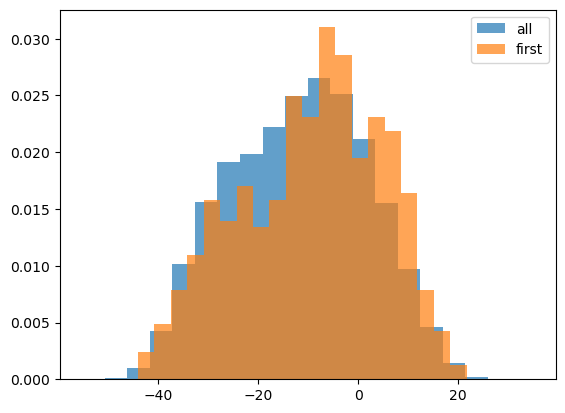

KstestResult(statistic=0.10159999999999997, pvalue=6.684835646912957e-05, statistic_location=-9.448140434212839, statistic_sign=1)


In [14]:
#plot normalized histograms of total potential energy over all ids vs only the first
import matplotlib.pyplot as plt
all_energies = [i['liquid_total_ene'] for i in energie_list]
all_energies_flat = [item for sublist in all_energies for item in sublist]
first_energies = energie_list[0]['liquid_total_ene']
plt.hist(all_energies_flat, bins=20, alpha=0.7, label='all', density=True)
plt.hist(first_energies, bins=20, alpha=0.7, label='first', density=True)
plt.legend(loc='upper right')
plt.show()
#also do a ks test to see if they are the same
from scipy.stats import ks_2samp
print(ks_2samp(all_energies_flat, first_energies))

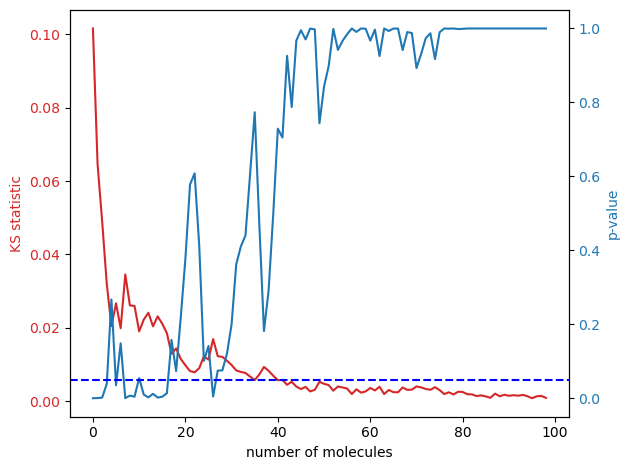

In [15]:
#okay, now lets get the statistic for each increment of adding one more molecule, seeing when it converges
KS_stat,pval = [],[]
for i in range(1,100):
    all_energies = [i['liquid_total_ene'] for i in energie_list]
    all_energies_flat = [item for sublist in all_energies for item in sublist]
    first_i_energies = [i['liquid_total_ene'] for i in energie_list[:i]]
    first_i_energies_flat = [item for sublist in first_i_energies for item in sublist]
    KS_stat.append(ks_2samp(all_energies_flat, first_i_energies_flat).statistic)
    pval.append(ks_2samp(all_energies_flat, first_i_energies_flat).pvalue)
#plot with double y axis; one for the KS statistic and one for the p-value
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('number of molecules')
ax1.set_ylabel('KS statistic', color=color)
ax1.plot(KS_stat, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('p-value', color=color)
ax2.plot(pval, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#plot horizontal line at 0.05 significance level
plt.axhline(y=0.05, color='b', linestyle='--')
fig.tight_layout()
plt.show()

In [16]:
def plot_ks(KS_stat,pval,ene=None):
    #plot with double y axis; one for the KS statistic and one for the p-value
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('number of molecules')
    ax1.set_ylabel('KS statistic', color=color)
    ax1.plot(KS_stat, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0,0.15)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('p-value', color=color)
    ax2.plot(pval, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0,1.1)
    #plot horizontal line at 0.05 significance level
    plt.axhline(y=0.05, color='b', linestyle='--')
    if ene:
        plt.title(ene)
    fig.tight_layout()

    plt.show()

def get_vals(term):
    KS_stat,pval = [],[]
    first_insignificane = False
    for i in range(1,100):
        all_energies = [ene[term] for ene in energie_list]
        all_energies_flat = [item for sublist in all_energies for item in sublist]
        first_i_energies = [ene[term] for ene in energie_list[:i]]
        first_i_energies_flat = [item for sublist in first_i_energies for item in sublist]
        KS_stat.append(ks_2samp(all_energies_flat, first_i_energies_flat).statistic)
        pval.append(ks_2samp(all_energies_flat, first_i_energies_flat).pvalue)
        if pval[-1] > 0.05 and not first_insignificane:
            print(f'Insignficant difference at {i} molecules for {term}')
            first_insignificane = True
    return KS_stat,pval

Insignficant difference at 1 molecules for liquid_intra_crf


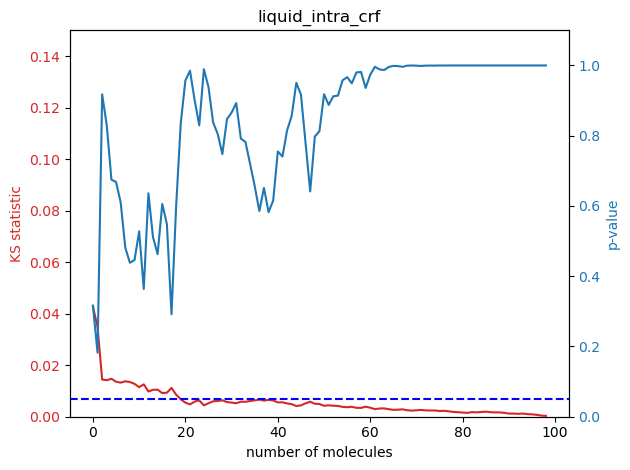

Insignficant difference at 2 molecules for liquid_intra_lj


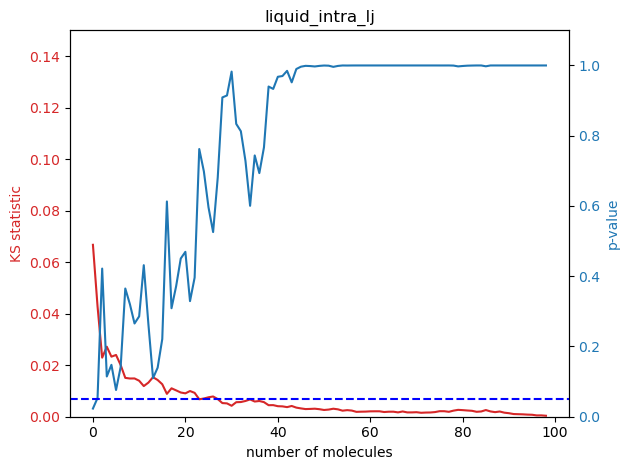

Insignficant difference at 1 molecules for liquid_total_crf


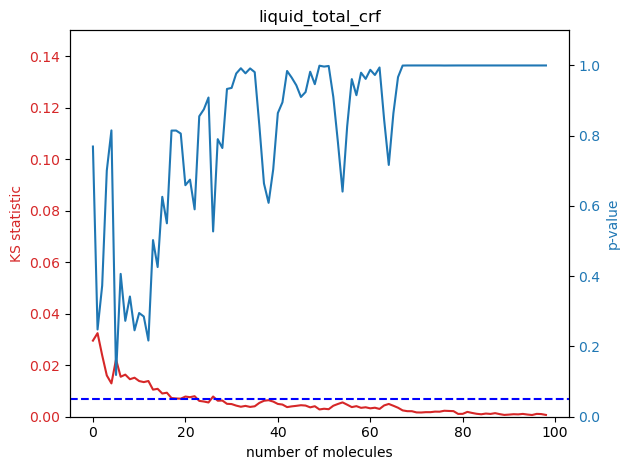

Insignficant difference at 5 molecules for liquid_total_lj


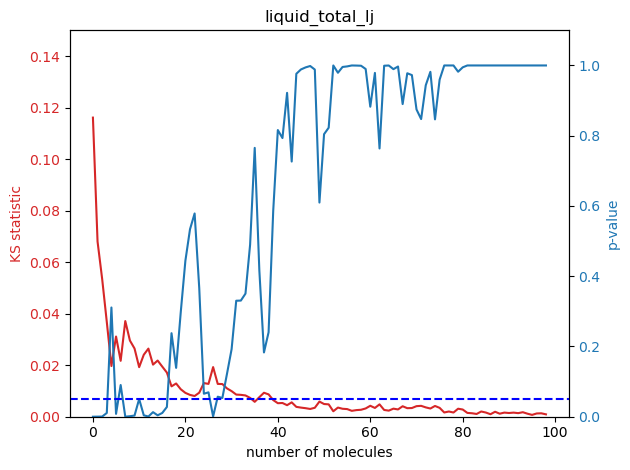

Insignficant difference at 3 molecules for liquid_intra_ene


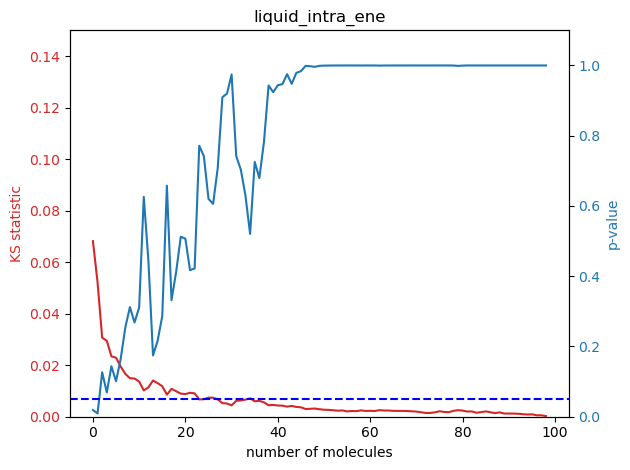

Insignficant difference at 5 molecules for liquid_total_ene


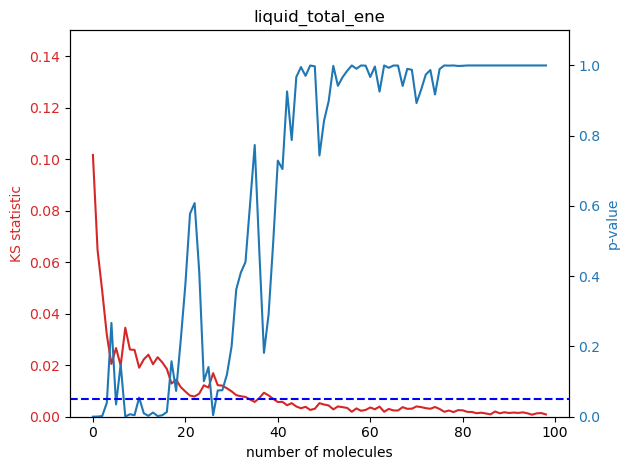

In [17]:
for energy in energie_list[0].keys():
    KS_stat,pval = get_vals(energy)
    plot_ks(KS_stat,pval,energy)

In [18]:
#

Insignficant difference at 1 molecules for liquid_intra_crf


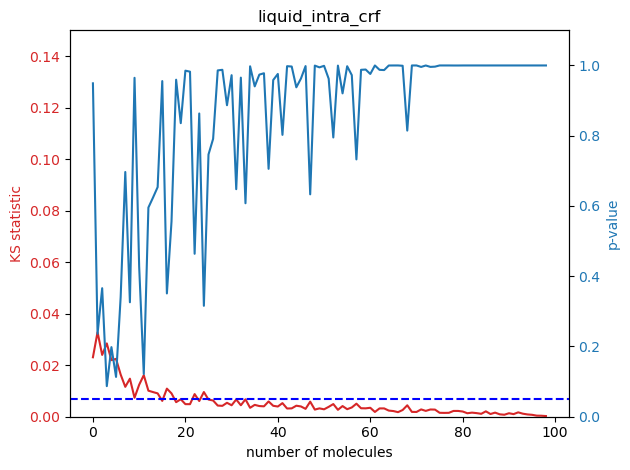

Insignficant difference at 1 molecules for liquid_intra_lj


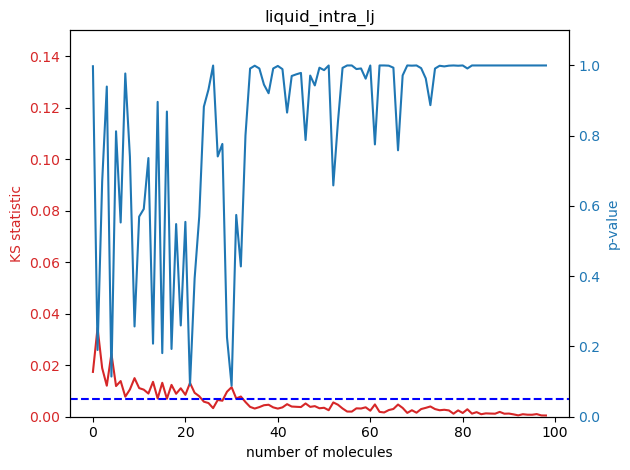

Insignficant difference at 1 molecules for liquid_total_crf


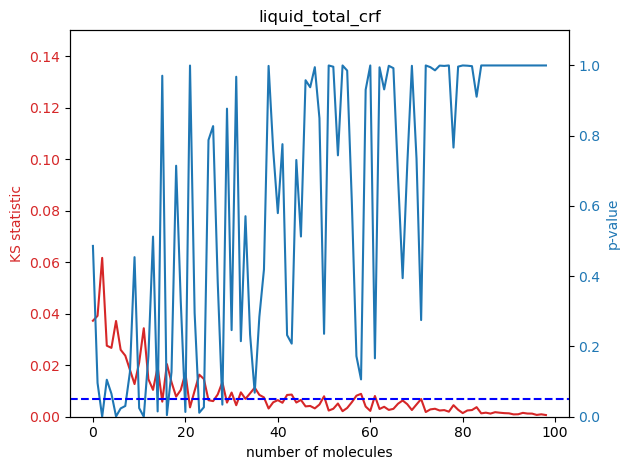

Insignficant difference at 1 molecules for liquid_total_lj


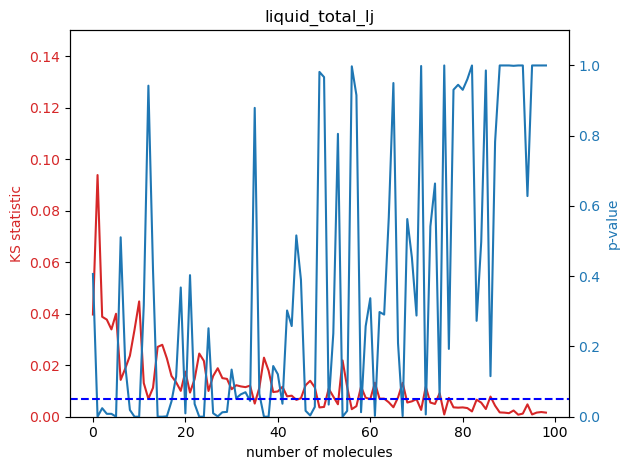

Insignficant difference at 1 molecules for liquid_intra_ene


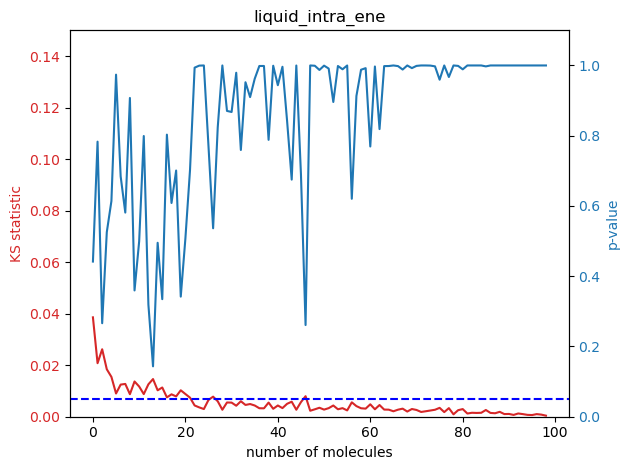

Insignficant difference at 2 molecules for liquid_total_ene


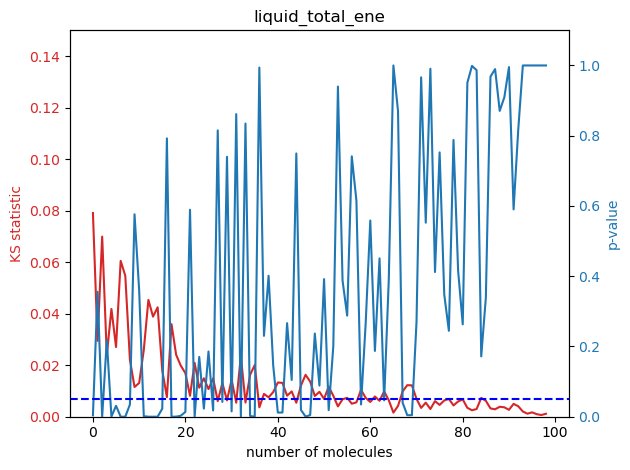

In [56]:
#try a similar thing, but this time randomly pick x molecules (instead of the first x molecules)
def get_vals_random(term):
    KS_stat,pval = [],[]
    first_insignificane = False
    for i in range(1,100):
        all_energies = [ene[term] for ene in energie_list]
        all_energies_flat = [item for sublist in all_energies for item in sublist]
        energie_list_shuffled = np.random.choice(energie_list,100,replace=False)
        random_i_energies = [ene[term] for ene in energie_list_shuffled[:i]]
        random_i_energies_flat = [item for sublist in random_i_energies for item in sublist]
        KS_stat.append(ks_2samp(all_energies_flat, random_i_energies_flat).statistic)
        pval.append(ks_2samp(all_energies_flat, random_i_energies_flat).pvalue)
        if pval[-1] > 0.05 and not first_insignificane:
            print(f'Insignficant difference at {i} molecules for {term}')
            first_insignificane = True
    return KS_stat,pval

for energy in energie_list[0].keys():
    KS_stat,pval = get_vals_random(energy)
    plot_ks(KS_stat,pval,energy)

In [41]:
term = 'liquid_total_ene'
i = 99
all_energies = [ene[term] for ene in energie_list]
all_energies_flat = [item for sublist in all_energies for item in sublist]
random_i_energies = [ene[term] for ene in np.random.choice(energie_list,i)]
random_i_energies_flat = [item for sublist in random_i_energies for item in sublist]
ks_2samp(all_energies_flat, random_i_energies_flat)



KstestResult(statistic=0.011512929292929297, pvalue=0.0027158812701294044, statistic_location=-16.237925924592066, statistic_sign=1)

In [30]:
len(random_i_energies_flat),len(all_energies_flat)

(49500, 50000)

In [31]:
ks_2samp(all_energies_flat, all_energies_flat)


KstestResult(statistic=0.0, pvalue=1.0, statistic_location=-55.28089167065802, statistic_sign=1)

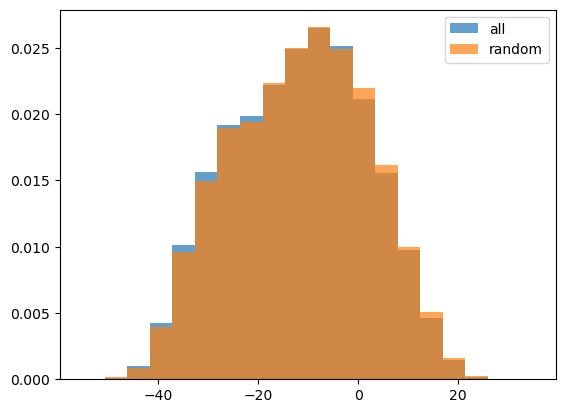

In [42]:
#plot
plt.hist(all_energies_flat, bins=20, alpha=0.7, label='all', density=True)
plt.hist(random_i_energies_flat, bins=20, alpha=0.7, label='random', density=True)
plt.legend(loc='upper right')
plt.show()


In [24]:
#print mean, median and st of both
print(np.mean(all_energies_flat),np.median(all_energies_flat),np.std(all_energies_flat))
print(np.mean(random_i_energies_flat),np.median(random_i_energies_flat),np.std(random_i_energies_flat))
#set 'all' at 100%, calculate how these values compare (so how many % are the mean, std, and median different for these two)
print(np.mean(random_i_energies_flat)/np.mean(all_energies_flat)*100)
print(np.median(random_i_energies_flat)/np.median(all_energies_flat)*100)
print(np.std(random_i_energies_flat)/np.std(all_energies_flat)*100)

-11.910145850410974 -11.300609008685388 13.642357572061023
-12.087665390573251 -11.462903567743464 13.734354103937005
101.49049006109487
101.43615763480835
100.67434482192716


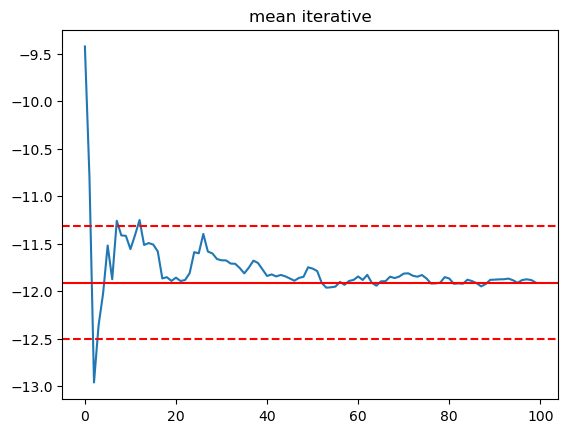

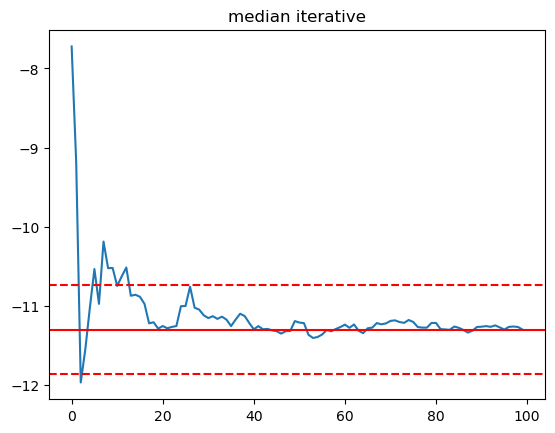

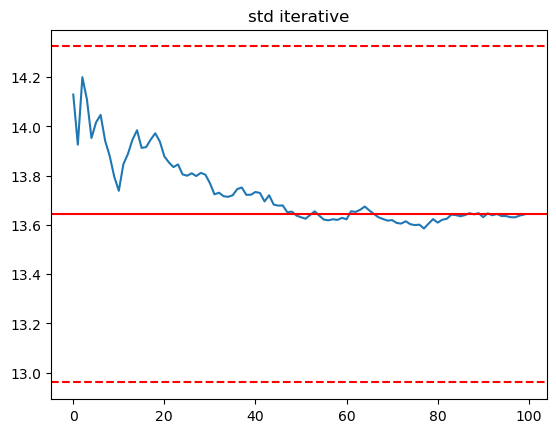

In [52]:
def get_moments_iterative(term):
    all_energies = [ene[term] for ene in energie_list]
    all_energies_flat = [item for sublist in all_energies for item in sublist]
    mean_all = np.mean(all_energies_flat)
    median_all = np.median(all_energies_flat)
    std_all = np.std(all_energies_flat)
    mean,median,std = [],[],[]
    for i in range(1,101):
        first_i_energies = [ene[term] for ene in energie_list[:i]]
        first_i_energies_flat = [item for sublist in first_i_energies for item in sublist]
        mean.append(np.mean(first_i_energies_flat))
        median.append(np.median(first_i_energies_flat))
        std.append(np.std(first_i_energies_flat))
    return mean,median,std,mean_all,median_all,std_all
        
def plot_convergence(value_list,ref,name):
    plt.plot(value_list)
    plt.axhline(y=ref, color='r', linestyle='-')
    #dashed lines at 5% difference
    plt.axhline(y=ref*0.95, color='r', linestyle='--')
    plt.axhline(y=ref*1.05, color='r', linestyle='--')
    plt.title(name)
    plt.show()

mean,median,std,mean_all,median_all,std_all = get_moments_iterative('liquid_total_ene')
plot_convergence(mean,mean_all,'mean iterative')
plot_convergence(median,median_all,'median iterative')
plot_convergence(std,std_all,'std iterative')

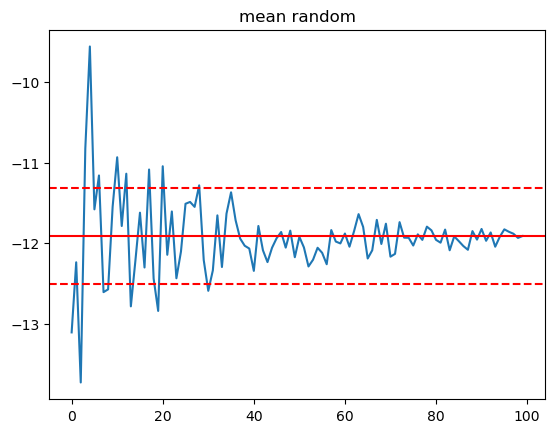

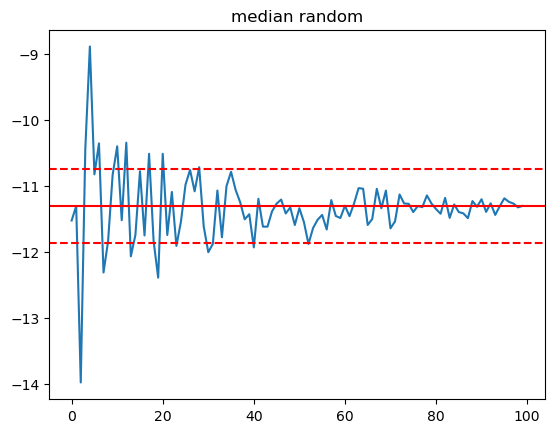

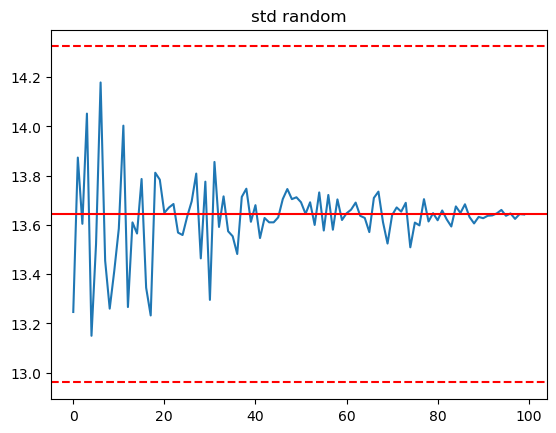

In [53]:
def get_moments_random(term):
    all_energies = [ene[term] for ene in energie_list]
    all_energies_flat = [item for sublist in all_energies for item in sublist]
    mean_all = np.mean(all_energies_flat)
    median_all = np.median(all_energies_flat)
    std_all = np.std(all_energies_flat)
    mean,median,std = [],[],[]
    for i in range(1,101):
        energie_list_shuffled = np.random.choice(energie_list,100,replace=False)
        random_i_energies = [ene[term] for ene in energie_list_shuffled[:i]]
        random_i_energies_flat = [item for sublist in random_i_energies for item in sublist]
        mean.append(np.mean(random_i_energies_flat))
        median.append(np.median(random_i_energies_flat))
        std.append(np.std(random_i_energies_flat))
    return mean,median,std,mean_all,median_all,std_all

mean,median,std,mean_all,median_all,std_all = get_moments_random('liquid_total_ene')
plot_convergence(mean,mean_all,'mean random')
plot_convergence(median,median_all,'median random')
plot_convergence(std,std_all,'std random')


In [57]:
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n1000_5ns.h5'
key = '0071386446c342529f1bb7c14316c4e7'
energie_list = []
from tqdm import tqdm
for i in tqdm(range(1000)):
    energies = get_energies_custom_idx(key,path,i)
    energie_list.append(energies)
#save as pickle
import pickle
with open("energies_1000_benzene_5ns.pkl", "wb") as f:
    pickle.dump(energie_list, f)

  0%|          | 0/1000 [00:00<?, ?it/s]/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')
  0%|          | 1/1000 [01:00<16:48:44, 60.59s/it]


KeyboardInterrupt: 

In [60]:
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n1000_5ns.h5'
key = '0071386446c342529f1bb7c14316c4e7'
energie_list = []
from tqdm import tqdm
for i in tqdm(range(1000)):
    energies = get_energies_custom_idx(key,path,i)
    energie_list.append(energies)
#save as pickle
import pickle
with open("energies_1000_benzene_5ns.pkl", "wb") as f:
    pickle.dump(energie_list, f)

  0%|          | 1/1000 [00:41<11:34:19, 41.70s/it]


KeyboardInterrupt: 

In [59]:
path = 'liquid_phase_experiment_daata/test_benzene_full_equil_n1000.h5'
key = '0071386446c342529f1bb7c14316c4e7'
energie_list = []
from tqdm import tqdm
for i in tqdm(range(1000)):
    energies = get_energies_custom_idx(key,path,i)
    energie_list.append(energies)
#save as pickle
import pickle
with open("energies_1000_benzene_50ps.pkl", "wb") as f:
    pickle.dump(energie_list, f)

  0%|          | 3/1000 [01:03<5:51:34, 21.16s/it]


KeyboardInterrupt: 